<a href="https://colab.research.google.com/github/edsonportosilva/OptiCommPy/blob/main/jupyter/test_WDM_transmission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulation of coherent WDM transmission

In [1]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install . 

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from optic.dsp.core import pulseShape, firFilter, decimate, symbolSync, pnorm, signal_power
from optic.models.devices import pdmCoherentReceiver, basicLaserModel

try:
    from optic.models.modelsGPU import manakovSSF
except:
    from optic.models.channels import manakovSSF

from optic.models.tx import simpleWDMTx
from optic.utils import parameters
from optic.dsp.equalization import edc, mimoAdaptEqualizer
from optic.dsp.carrierRecovery import cpr
from optic.comm.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, calcEVM
from optic.plot import pconst

import scipy.constants as const

from optic.models.amplification import edfaSM,OSA

import os.path as path

In [3]:
import logging as logg
logg.getLogger().setLevel(logg.INFO)
logg.basicConfig(format='%(message)s')

In [4]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize

In [5]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

figsize(10, 3)

In [6]:
# %load_ext autoreload
# %autoreload 2
# %load_ext line_profiler


## Parameters

In [18]:
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 16  # order of the modulation format
paramTx.Rs  = 32e9 # symbol rate [baud]
paramTx.SpS = 16  # samples per symbol
paramTx.pulse = 'rrc' # pulse shaping filter
paramTx.nPulseTaps = 4096 # number of pulse shaping filter coefficients
paramTx.pulseRollOff = 0.01 # RRC rolloff
paramTx.powerPerChannel = -2 # power per WDM channel [dBm]
paramTx.nChannels = 11 # number of WDM channels
paramTx.Fc = 193.1e12 # central optical frequency of the WDM spectrum
paramTx.laserLinewidth = 100e3 # laser linewidth in Hz
paramTx.wdmGridSpacing = 37.5e9 # WDM grid spacing
paramTx.nPolModes = 2  # number of signal modes [2 for polarization multiplexed signals]
paramTx.nBits = int(np.log2(paramTx.M)*1e5) # total number of bits per polarization

In [19]:
# Optical channel parameters
paramCh = parameters()
paramCh.Ltotal = 100     # total link distance [km]
paramCh.Lspan  = 100      # span length [km]
paramCh.alpha = 0.2      # fiber loss parameter [dB/km]
paramCh.D = 16           # fiber dispersion parameter [ps/nm/km]
paramCh.gamma = 1.3      # fiber nonlinear parameter [1/(W.km)]
paramCh.Fc = paramTx.Fc  # central optical frequency of the WDM spectrum
paramCh.hz = 0.5         # step-size of the split-step Fourier method [km]
paramCh.maxIter = 5      # maximum number of convergence iterations per step
paramCh.tol = 1e-5       # error tolerance per step
paramCh.nlprMethod = True # use adaptive step-size based o maximum nonlinear phase-shift
paramCh.maxNlinPhaseRot = 2e-2 # maximum nonlinear phase-shift per step
paramCh.amp = None       # no optical amplification
paramCh.prgsBar = True   # show progress bar
paramCh.Fs = paramTx.Rs*paramTx.SpS # sampling rate

Fs = paramCh.Fs

In [20]:
# EDFA parameters
param_edfa = parameters()
# gain control
param_edfa.type     = "AGC"
param_edfa.value    = 20
# pid - gain control
param_edfa.kp = 1e-2
param_edfa.ki = 1e-2
param_edfa.kd = 5e-2
# pump information
param_edfa.forPump  = {'pump_signal': np.array([100e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.bckPump  = {'pump_signal': np.array([000e-3]), 'pump_lambda': np.array([980e-9])}
# giles parameters
param_edfa.file     = 'giles_MP980.dat'
param_edfa.fileunit = 'nm'
param_edfa.gmtc     = 'Bessel'
param_edfa.tol      = 3/100
param_edfa.tolCtrl  = 0.5
param_edfa.noiseBand= 12.5e9

In [21]:
if 'google.colab' in str(get_ipython()):  
  param_edfa.file = path.join(path.abspath(path.join("../")), 'OptiCommPy', 'optic', 'models', 'ampParams', param_edfa.file)
else:
  param_edfa.file = path.join(path.abspath(path.join("../")), 'optic', 'models', 'ampParams', param_edfa.file)

## Simulation

### Singal generation, propagation, amplification and reception

**Polarization multiplexed WDM signal generation**

In [22]:
# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

  0%|          | 0/11 [00:00<?, ?it/s]

channel 0	 fc : 192.9125 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 0	 power: -2.00 dBm

channel 1	 fc : 192.9500 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 1	 power: -2.00 dBm

channel 2	 fc : 192.9875 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 2	 power: -2.00 dBm

channel 3	 fc : 193.0250 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 3	 power: -2.00 dBm

channel 4	 fc : 193.0625 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 4	 power: -2.00 dBm

channel 5	 fc : 193.1000 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 5	 power: -2.00 dBm

channel 6	 fc : 193.1375 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 6	 power: -2.00 dBm

channel 7	 fc : 193.1750 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
channel 7	 power: -2.00 dBm

channel 8	 fc : 193.2125 THz
  mode #0	 power: -5.01 dBm
  mode #1	 power: -5.01 dBm
cha

In [23]:
print('Average power of the modulated optical signal [mW]: %.3f mW'%(signal_power(sigWDM_Tx)/1e-3))
print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(signal_power(sigWDM_Tx)/1e-3)))

Average power of the modulated optical signal [mW]: 6.940 mW
Average power of the modulated optical signal [dBm]: 8.414 dBm


(-80.0, -40.0)

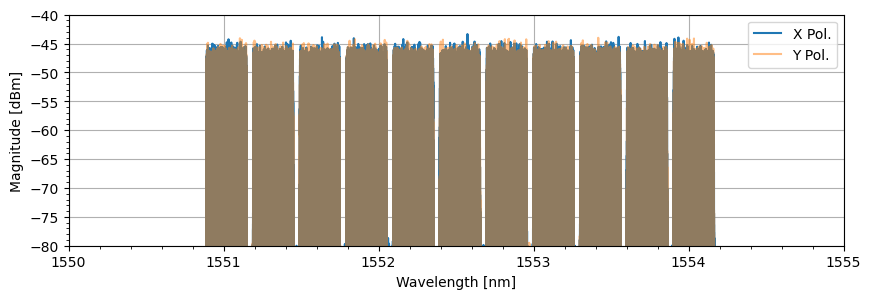

In [24]:
ax = OSA(sigWDM_Tx, Fs, paramTx.Fc)
ax.set_xlim([1550,1555])
ax.set_ylim([-80,-40])

**Nonlinear fiber propagation with the split-step Fourier method**

In [25]:
# nonlinear signal propagation
sigWDM = manakovSSF(sigWDM_Tx, paramCh)

Running Manakov SSF model on GPU...


  0%|          | 0/1 [00:00<?, ?it/s]

(-80.0, -40.0)

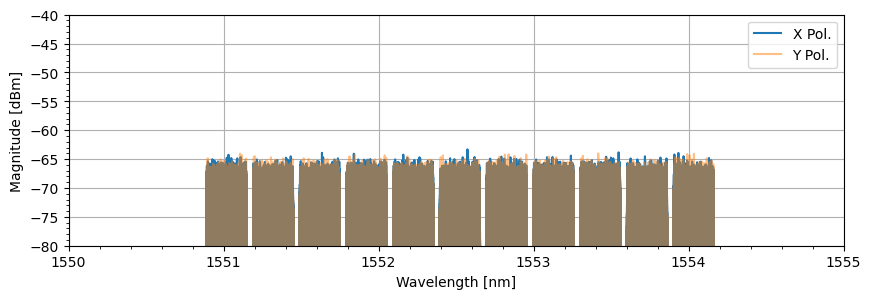

In [26]:

ax = OSA(sigWDM, Fs, paramTx.Fc)
ax.set_xlim([1550,1555])
ax.set_ylim([-80,-40])

In [27]:

prog_pw = signal_power(sigWDM)/1e-3 #np.sum(1000*np.mean(sigWDM * np.conj(sigWDM), axis = 0).real)
print('Average power of the modulated optical signal [mW]: %.3f mW'%(prog_pw))
print('Average power of the modulated optical signal [dBm]: %.3f dBm'%(10*np.log10(prog_pw)))

Average power of the modulated optical signal [mW]: 0.069 mW
Average power of the modulated optical signal [dBm]: -11.586 dBm


**Optical amplification using an EDFA**

In [28]:
sigWDM_Amp, PumpF, PumpB, noisef  = edfaSM(sigWDM, Fs, paramTx.Fc, param_edfa)


EDF absorption and gain coeficients. Calculating absorption and emission cross-section ...
EDFA SM: loop  1
Convergence: 0.027%.

EDFA SM: control loop  1
Convergence: 6.479 dB
Pump for.: 50.00 mW

EDFA SM: loop  1
Convergence: -99.708%.

EDFA SM: loop  2
Convergence: 1.023%.

EDFA SM: control loop  2
Convergence: 3.597 dB
Pump for.: 25.00 mW

EDFA SM: loop  1
Convergence: -98.100%.

EDFA SM: loop  2
Convergence: -0.307%.



In [29]:
rx_pw = 1e3*signal_power(sigWDM_Amp)
print('Forward pump  - [mW] : %.3f' %(1e3*PumpF[0]))
print('Backward pump - [mW] : %.3f' %(1e3*PumpB[1]))
print('Average power - RX amp [mW] : %.3f' %(rx_pw))
print('Average power - RX amp [dBm] : %.3f' %(10*np.log10(rx_pw)))
print('Gain [dB]: %.3f' %(10*np.log10(rx_pw/prog_pw)))

Forward pump  - [mW] : 25.000
Backward pump - [mW] : 0.000
Average power - RX amp [mW] : 6.809
Average power - RX amp [dBm] : 8.331
Gain [dB]: 19.917


(-80.0, -40.0)

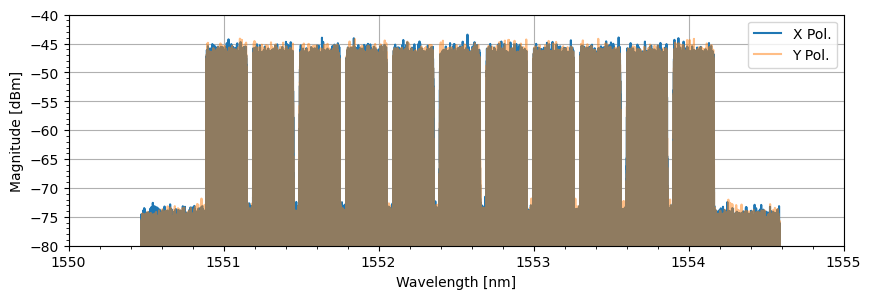

In [30]:

ax = OSA(sigWDM_Amp, Fs, paramTx.Fc)
ax.set_xlim([1550,1555])
ax.set_ylim([-80,-40])

**Optical WDM spectrum before and after transmission**

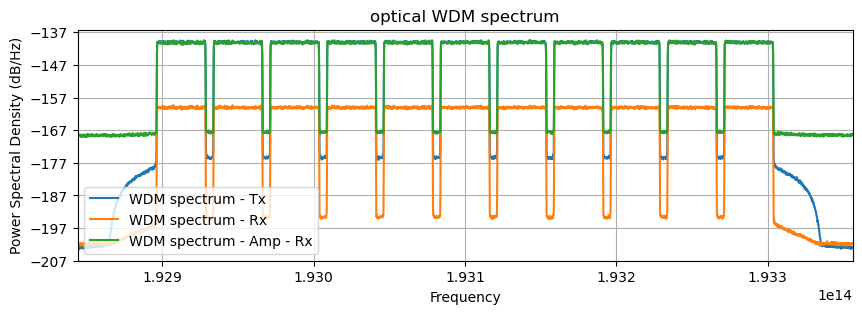

In [31]:
# plot psd
plt.figure(figsize=(10, 3))
plt.xlim(paramCh.Fc-Fs/2,paramCh.Fc+Fs/2);
plt.psd(sigWDM_Tx[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.psd(sigWDM_Amp[:,0], Fs=Fs, Fc=paramCh.Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Amp - Rx')
plt.legend(loc='lower left')
plt.title('optical WDM spectrum');

**WDM channels coherent detection and demodulation**

In [32]:
# parameters
chIndex  = int(np.floor(paramTx.nChannels/2))      # index of the channel to be demodulated

freqGrid = paramTx.wdmFreqGrid
π  = np.pi
t  = np.arange(0, len(sigWDM))*1/Fs

print('Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n'\
      %(chIndex, (paramCh.Fc + freqGrid[chIndex])/1e12, const.c/(paramCh.Fc + freqGrid[chIndex])/1e-9))

symbTx = symbTx_[:,:,chIndex]

# local oscillator (LO) parameters:
FO      = 150e6                 # frequency offset
Δf_lo   = freqGrid[chIndex]+FO  # downshift of the channel to be demodulated

# generate CW laser LO field
paramLO = parameters()
paramLO.P = 10              # power in dBm
paramLO.lw = 100e3          # laser linewidth
paramLO.RIN_var = 0
paramLO.Ns = len(sigWDM)
paramLO.Fs = Fs

sigLO = basicLaserModel(paramLO)
sigLO = sigLO*np.exp(1j*2*π*Δf_lo*t) # add frequency offset  

print('Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz\n'\
      %(paramLO.P, paramLO.lw/1e3, FO/1e6))

Demodulating channel #5 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 10.00 dBm, lw: 100.00 kHz, FO: 150.00 MHz



**polarization multiplexed coherent optical receiver**

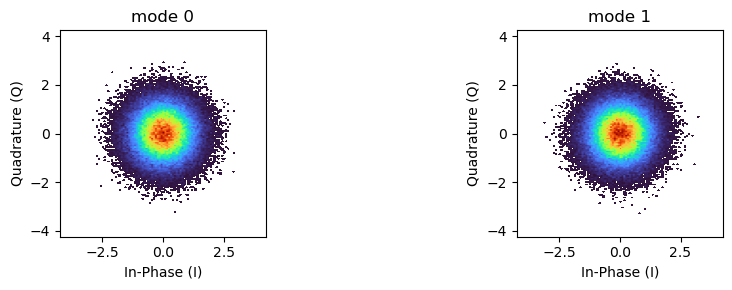

In [33]:
# photodiodes parameters
paramPD = parameters()
paramPD.B = paramTx.Rs
paramPD.Fs = Fs    
paramPD.ideal = True

θsig = π/3 # polarization rotation angle
sigRx = pdmCoherentReceiver(sigWDM_Amp, sigLO, θsig, paramPD)

# plot received constellations
pconst(sigRx[0::paramTx.SpS,:], R=3);

**Matched filtering and CD compensation**

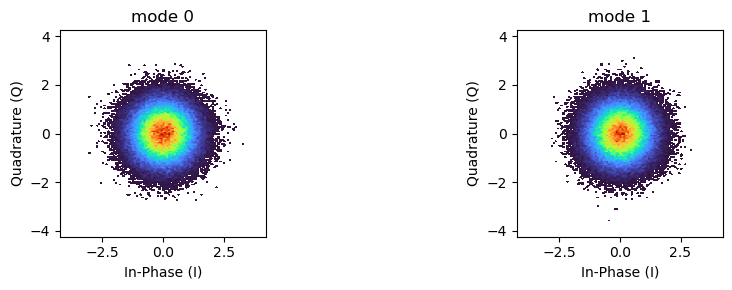

In [34]:
# Matched filtering
if paramTx.pulse == 'nrz':
    pulse = pulseShape('nrz', paramTx.SpS)
elif paramTx.pulse == 'rrc':
    pulse = pulseShape('rrc', paramTx.SpS, N=paramTx.nPulseTaps, alpha=paramTx.pulseRollOff, Ts=1/paramTx.Rs)

pulse = pnorm(pulse)
sigRx = firFilter(pulse, sigRx)

# plot constellations after matched filtering
pconst(sigRx[0::paramTx.SpS,:], R=3);

Running CD compensation...


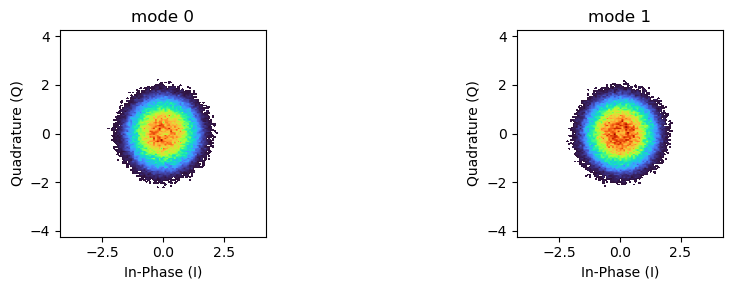

In [35]:
# CD compensation
paramEDC = parameters()
paramEDC.L = paramCh.Ltotal
paramEDC.D = paramCh.D
paramEDC.Fc = paramCh.Fc-Δf_lo
paramEDC.Fs = Fs

sigRx = edc(sigRx, paramEDC)

# plot constellations after CD compensation
pconst(sigRx[0::paramTx.SpS,:], R=3);

**Downsampling to 2 samples/symbol and re-synchronization with transmitted sequences**

In [36]:
# decimation
paramDec = parameters()
paramDec.SpS_in  = paramTx.SpS
paramDec.SpS_out = 2
sigRx = decimate(sigRx, paramDec)

symbRx = symbolSync(sigRx, symbTx, 2)

**Power normalization**

In [37]:
x = pnorm(sigRx)
d = pnorm(symbRx)

**Adaptive equalization**

Running adaptive equalizer...
da-rde - training stage #0
da-rde pre-convergence training iteration #0
da-rde MSE = 0.007957.
da-rde pre-convergence training iteration #1
da-rde MSE = 0.005566.
da-rde pre-convergence training iteration #2
da-rde MSE = 0.005512.
da-rde pre-convergence training iteration #3
da-rde MSE = 0.005474.
da-rde pre-convergence training iteration #4
da-rde MSE = 0.005448.
rde - training stage #1
rde MSE = 0.004196.


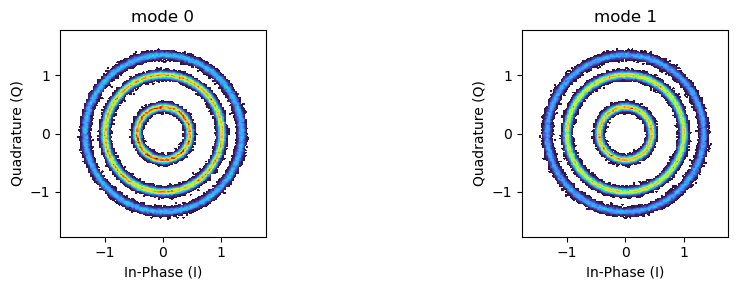

In [38]:
# adaptive equalization parameters
paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = paramDec.SpS_out
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.M = paramTx.M
paramEq.L = [int(0.2*d.shape[0]), int(0.8*d.shape[0])]
paramEq.prgsBar = False

if paramTx.M == 4:
    paramEq.alg = ['nlms','cma'] # QPSK
    paramEq.mu = [5e-3, 1e-3] 
else:
    paramEq.alg = ['da-rde','rde'] # M-QAM
    paramEq.mu = [5e-3, 2e-4] 

y_EQ = mimoAdaptEqualizer(x, paramEq, d)

#plot constellations after adaptive equalization
discard = 5000
pconst(y_EQ[discard:-discard,:]);

**Carrier phase recovery**

Running frequency offset compensation...
Running BPS carrier phase recovery...


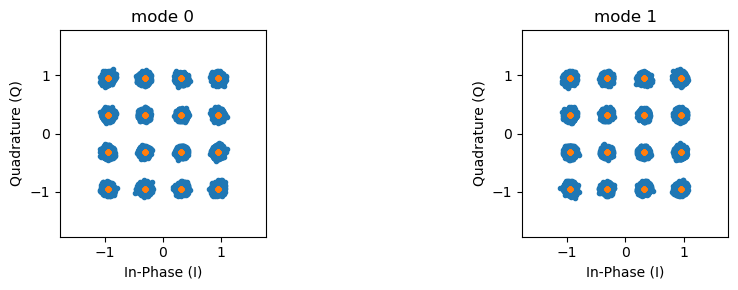

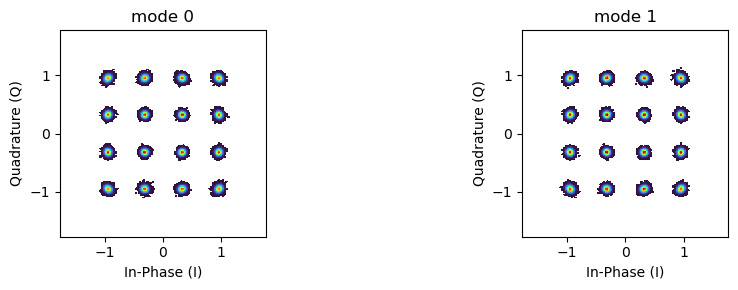

In [39]:
paramCPR = parameters()
paramCPR.alg = 'bps'
paramCPR.M   = paramTx.M
paramCPR.N   = 75
paramCPR.B   = 64

y_CPR = cpr(y_EQ, paramCPR)

discard = 500

#plot constellations after CPR
pconst([y_CPR[discard:-discard,:],d[discard:-discard,:]], pType='fast')
pconst(y_CPR[discard:-discard,:]);

### Evaluate transmission metrics

In [40]:
ind = np.arange(discard, d.shape[0]-discard)
BER, SER, SNR = fastBERcalc(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
GMI, NGMI = monteCarloGMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
MI       = monteCarloMI(y_CPR[ind,:], d[ind,:], paramTx.M, 'qam')
EVM      = calcEVM(y_CPR[ind,:], paramTx.M, 'qam', d[ind,:])

print('      pol.X      pol.Y      ')
print(' SER: %.2e,  %.2e'%(SER[0], SER[1]))
print(' BER: %.2e,  %.2e'%(BER[0], BER[1]))
print(' SNR: %.2f dB,  %.2f dB'%(SNR[0], SNR[1]))
print(' EVM: %.2f %%,    %.2f %%'%(EVM[0]*100, EVM[1]*100))
print('  MI: %.2f bits, %.2f bits'%(MI[0], MI[1]))
print(' GMI: %.2f bits, %.2f bits'%(GMI[0], GMI[1]))
print('NGMI: %.2f,      %.2f'%(NGMI[0], NGMI[1]))

      pol.X      pol.Y      
 SER: 0.00e+00,  0.00e+00
 BER: 0.00e+00,  0.00e+00
 SNR: 26.13 dB,  26.15 dB
 EVM: 0.24 %,    0.24 %
  MI: 4.00 bits, 4.00 bits
 GMI: 4.00 bits, 4.00 bits
NGMI: 1.00,      1.00
